IBM Capstone - BATTLE OF THE NEIGHBORHOODS

1.	Purpose 
This document provides the details of my final peer reviewed assignment for the IBM Data Science Professional Certificate program – Coursera Capstone.
2.	Problem statement 
Singapore is City state located in busiest shipping lanes in the world; it’s a small island nation with a thriving tourism industry. The internet provides host of information to visit and stay in and around Singapore. However, most of the recommendations are simply based on usual tourist attractions or residential areas that are mostly expensive or already known for travellers based on certain keywords like "Hotel", or "Backpackers" etc. The intention on this project is to collect and provide a data driven recommendation that can supplement the recommendation with statistical data. This will also be utilizing data retrieved from Singapore open data sources and FourSquare API venue recommendations.
3.	Data Sources 
This demonstration will make use of the following data sources:

•	Singapore Towns and median residential rental prices
Data will retrieved from Singapore open dataset from median rent by town and flattype from https://data.gov.sg website. 
•	Singapore Towns location data retrieved using Google maps API
•	Singapore Top Venue Recommendations from FourSquare API


In [1]:
import numpy as np 
import pandas as pd 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize #

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import folium 

import requests 
import lxml.html as lh
import bs4 as bs
import urllib.request

print('Libraries imported.')

Libraries imported.


File was downloaded from webpage and imported here 

In [2]:
import zipfile
zf = zipfile.ZipFile('./median-rent-by-town-and-flat-type.zip')
sgp_median_rent_by_town_data = pd.read_csv(zf.open("median-rent-by-town-and-flat-type.csv"))
sgp_median_rent_by_town_data.rename(columns = {'town':'Town'}, inplace = True)
sgp_median_rent_by_town_data.head()

,quarter,Town,flat_type,median_rent
0,2005-Q2,ANG MO KIO,1-RM,na
1,2005-Q2,ANG MO KIO,2-RM,na
2,2005-Q2,ANG MO KIO,3-RM,800
3,2005-Q2,ANG MO KIO,4-RM,950
4,2005-Q2,ANG MO KIO,5-RM,-


4. Data Cleansing and preprocessing 

Data Cleansing 

In [3]:
# Drop rows with rental price == 'na'.
sgp_median_rent_by_town_data_filter=sgp_median_rent_by_town_data[~sgp_median_rent_by_town_data['median_rent'].isin(['-','na'])]

# Lookinga the recent Data "2020-Q1"
sgp_median_rent_by_town_data_filter=sgp_median_rent_by_town_data_filter[sgp_median_rent_by_town_data_filter['quarter'] == "2020-Q1"]

# Data not needed are dropped 
sgp_median_rent_by_town_data_filter=sgp_median_rent_by_town_data_filter.drop(['quarter'], axis=1)

# Data type verification and change as needed
sgp_median_rent_by_town_data_filter['median_rent']=sgp_median_rent_by_town_data_filter['median_rent'].astype(np.float64)

In [4]:
singapore_average_rental_prices_by_town = sgp_median_rent_by_town_data_filter.groupby(['Town'])['median_rent'].mean().reset_index()
singapore_average_rental_prices_by_town

,Town,median_rent
0,ANG MO KIO,2066.666667
1,BEDOK,2120.000000
2,BISHAN,2233.333333
3,BUKIT BATOK,1950.000000
4,BUKIT MERAH,2162.500000
5,BUKIT PANJANG,1750.000000
6,CENTRAL,2400.000000
7,CHOA CHU KANG,1933.333333
8,CLEMENTI,2250.000000
9,GEYLANG,2200.000000


Georeferencing the towns 

In [5]:
if {0}:
    geo = Nominatim(user_agent='Mypythonapi')
    for idx,town in singapore_average_rental_prices_by_town['Town'].iteritems():
        coord = geo.geocode(town + ' ' + "Singapore", timeout = 10)
        if coord:
            singapore_average_rental_prices_by_town.loc[idx,'Latitude'] = coord.latitude
            singapore_average_rental_prices_by_town.loc[idx,'Longitude'] = coord.longitude
        else:
            singapore_average_rental_prices_by_town.loc[idx,'Latitude'] = NULL
            singapore_average_rental_prices_by_town.loc[idx,'Longitude'] = NULL

In [6]:
singapore_average_rental_prices_by_town.set_index("Town")

,median_rent,Latitude,Longitude
Town,,,
ANG MO KIO,2066.666667,1.370073,103.849516
BEDOK,2120.000000,1.323976,103.930216
BISHAN,2233.333333,1.350986,103.848255
BUKIT BATOK,1950.000000,1.349057,103.749591
BUKIT MERAH,2162.500000,1.270439,103.828318
BUKIT PANJANG,1750.000000,1.378629,103.762136
CENTRAL,2400.000000,1.340863,103.830392
CHOA CHU KANG,1933.333333,1.384749,103.744534
CLEMENTI,2250.000000,1.315100,103.765231


In [7]:
geo = Nominatim(user_agent='My-IBMNotebook')
address = 'Singapore'
location = geo.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore {}, {}.'.format(latitude, longitude))

# creating map of Singapore using latitude and longitude values
map_singapore = folium.Map(location=[latitude, longitude],tiles="OpenStreetMap", zoom_start=10)

# adding markers to map
for lat, lng, town in zip(
    singapore_average_rental_prices_by_town['Latitude'],
    singapore_average_rental_prices_by_town['Longitude'],
    singapore_average_rental_prices_by_town['Town']):
    label = town
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
        parse_html=False).add_to(map_singapore)
map_singapore

The geograpical coordinate of Singapore 1.357107, 103.8194992.


Segmenting and Clustering Towns in Singapore

In [8]:
CLIENT_ID = 'JF33NPFBER0RV24JN5RVLK50AJVU1NY13CSCLLSOWGAZVPS1' # Foursquare ID
CLIENT_SECRET = 'TBEJ1E1FLB2PI0P0HVTMOPM4DMITRQTEWDLYYFX5LDUCIZBK' #  Foursquare Secret
VERSION = '20200524' # Foursquare API version
LIMIT = 80

In [9]:
import time
# ---------------------------------------------
# The following function retrieves the venues given the names and coordinates and stores it into dataframe.
FOURSQUARE_EXPLORE_URL = 'https://api.foursquare.com/v2/venues/explore?'
FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/venues/search?'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('getNearbyVenues',names)
       
        # create the API request URL
        url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FOURSQUARE_EXPLORE_URL,CLIENT_ID,CLIENT_SECRET,VERSION,
            lat,lng,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,lat,lng, 
            v['venue']['id'],v['venue']['name'], 
            v['venue']['location']['lat'],v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        time.sleep(2)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town','Town Latitude','Town Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    
    return(nearby_venues)

In [10]:
FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/venues/search?'
# SEARCH VENUES BY CATEGORY

# Dataframe : venue_id_recover 
# - store venue id to recover failed venues id score retrieval later if foursquare limit is exceeded when getting score.
venue_id_rcols = ['VenueID']
venue_id_recover = pd.DataFrame(columns=venue_id_rcols)

def getVenuesByCategory(names, latitudes, longitudes, categoryID, radius=500):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    venue_columns = ['Town','Town Latitude','Town Longitude','VenueID','VenueName','score','category','catID','latitude','longitude']
    venue_DF = pd.DataFrame(columns=venue_columns)
    print("[#Start getVenuesByCategory]")
    for name, lat, lng in zip(names, latitudes, longitudes):
        #cyclefsk2()
        print(name,",",end='')
        #print('getVenuesByCategory',categoryID,name) ; # DEBUG: be quiet
        # create the API request URL
        url = '{}client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            FOURSQUARE_SEARCH_URL,CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT,categoryID)
        # make the GET request
        results = requests.get(url).json()
        # Populate dataframe with the category venue results
        # Extracting JSON  data values
        
        for jsonSub in results['response']['venues']:
            #print(jsonSub)
            # JSON Results may not be in expected format or incomplete data, in that case, skip!
            ven_id = 0
            try:
                # If there are any issue with a restaurant, retry or ignore and continue
                # Get location details
                ven_id   = jsonSub['id']
                ven_cat  = jsonSub['categories'][0]['pluralName']
                ven_CID  = jsonSub['categories'][0]['id']
                ven_name = jsonSub['name']
                ven_lat  = jsonSub['location']['lat']
                ven_lng  = jsonSub['location']['lng']
                venue_DF = venue_DF.append({
                    'Town'      : name,
                    'Town Latitude' : lat,
                    'Town Longitude': lng,
                    'VenueID'   : ven_id,
                    'VenueName' : ven_name,
                    'category'  : ven_cat,
                    'catID'     : ven_CID,
                    'latitude'  : ven_lat,
                    'longitude' : ven_lng}, ignore_index=True)
            except:
                continue
    # END OF LOOP, return.
    print("\n[#Done getVenuesByCategory]")
    return(venue_DF)

In [11]:
singapore_average_rental_prices_by_town.dtypes

Town            object
median_rent    float64
Latitude       float64
Longitude      float64
dtype: object

In [12]:
venue_columns = ['Town','Town Latitude','Town Longitude','VenueID','VenueName','category','catID','latitude','longitude']
singapore_town_venues = pd.DataFrame(columns=venue_columns)

In [13]:
categoryID = "4d4b7105d754a06374d81259"
town_names = singapore_average_rental_prices_by_town['Town']
lat_list   = singapore_average_rental_prices_by_town['Latitude']
lng_list   = singapore_average_rental_prices_by_town['Longitude']
singapore_food_venues = getVenuesByCategory(names=town_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)

[#Start getVenuesByCategory]
ANG MO KIO ,BEDOK ,BISHAN ,BUKIT BATOK ,BUKIT MERAH ,BUKIT PANJANG ,CENTRAL ,CHOA CHU KANG ,CLEMENTI ,GEYLANG ,HOUGANG ,JURONG EAST ,JURONG WEST ,KALLANG/WHAMPOA ,MARINE PARADE ,PASIR RIS ,PUNGGOL ,QUEENSTOWN ,SEMBAWANG ,SENGKANG ,SERANGOON ,TAMPINES ,TOA PAYOH ,WOODLANDS ,YISHUN ,
[#Done getVenuesByCategory]


In search of Outdoor and recreation activites 

In [35]:
if (0):
    # Outdoors & Recreation, 
    categoryID = "4d4b7105d754a06377d81259"
    town_names = singapore_average_rental_prices_by_town['Town']
    lat_list   = singapore_average_rental_prices_by_town['Latitude']
    lng_list   = singapore_average_rental_prices_by_town['Longitude']
    singapore_outdoor_venues_by_town = getVenuesByCategory(names=town_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)

In search of Nightlife 

In [15]:
if (0):
    #Nightlife Spot = 4d4b7105d754a06376d81259
    categoryID = "4d4b7105d754a06376d81259"
    town_names = singapore_average_rental_prices_by_town['Town']
    lat_list   = singapore_average_rental_prices_by_town['Latitude']
    lng_list   = singapore_average_rental_prices_by_town['Longitude']
    singapore_Nightlife_by_town = getVenuesByCategory(names=town_names,latitudes=lat_list,longitudes=lng_list,categoryID=categoryID)

In [16]:
# If all categories are called
if (0):
    singapore_town_venues = pd.concat([singapore_food_venues,singapore_outdoor_venues_by_town,singapore_Nightlife_by_town], ignore_index=True)
#else
singapore_town_venues = singapore_food_venues
singapore_town_venues.shape

(1201, 10)

Removing unwanted data's

In [18]:
# Eliminate possible venue duplicates.
singapore_town_venues = singapore_town_venues[venue_columns]
# Drop rows with missing elements
singapore_town_venues = singapore_town_venues.dropna(axis='columns')

In [19]:
singapore_town_venues= singapore_town_venues.fillna(0)
singapore_town_venues.dtypes

Town               object
Town Latitude     float64
Town Longitude    float64
VenueID            object
VenueName          object
category           object
catID              object
latitude          float64
longitude         float64
dtype: object

In [20]:
singapore_town_venues.head()

,Town,Town Latitude,Town Longitude,VenueID,VenueName,category,catID,latitude,longitude
0,ANG MO KIO,1.370073,103.849516,538ef3d5498e088ff4b1e8ba,Koi Café Express,Bubble Tea Shops,52e81612bcbc57f1066b7a0c,1.369342,103.849820
1,ANG MO KIO,1.370073,103.849516,5d48d8dfdae4eb0008d85e5a,A&W,Fast Food Restaurants,4bf58dd8d48988d16e941735,1.369541,103.849043
2,ANG MO KIO,1.370073,103.849516,5c28481461f070002c835dba,山城 Shan Cheng,Chinese Restaurants,4bf58dd8d48988d145941735,1.369282,103.848771
3,ANG MO KIO,1.370073,103.849516,4b83bd62f964a520c80e31e3,McDonald's/McCafe,Fast Food Restaurants,4bf58dd8d48988d16e941735,1.369385,103.847365
4,ANG MO KIO,1.370073,103.849516,4effc02af790570bd21da0c9,Burger King,Fast Food Restaurants,4bf58dd8d48988d16e941735,1.368926,103.848004


In [21]:
singapore_town_venues.to_csv('SG_Data.csv')

In [22]:
singapore_town_venues.groupby('Town')['VenueID'].count()

Town
ANG MO KIO         50
BEDOK              50
BISHAN             50
BUKIT BATOK        50
BUKIT MERAH        49
BUKIT PANJANG      50
CENTRAL             4
CHOA CHU KANG      50
CLEMENTI           50
GEYLANG            50
HOUGANG            50
JURONG EAST        50
JURONG WEST        50
KALLANG/WHAMPOA    50
MARINE PARADE      50
PASIR RIS          50
PUNGGOL            50
QUEENSTOWN         48
SEMBAWANG          50
SENGKANG           50
SERANGOON          50
TAMPINES           50
TOA PAYOH          50
WOODLANDS          50
YISHUN             50
Name: VenueID, dtype: int64

In [23]:
# Count number of categories that can be curated.
print('There are {} uniques categories.'.format(len(singapore_town_venues['category'].unique())))

There are 91 uniques categories.


In [24]:
# Check top 10 most frequently occuring venue type
singapore_town_venues.groupby('category')['VenueName'].count().sort_values(ascending=False)[:20]

category
Food Courts              137
Coffee Shops             114
Chinese Restaurants      105
Fast Food Restaurants     76
Bakeries                  62
Cafés                     56
Asian Restaurants         48
Noodle Houses             39
Snack Places              33
Dessert Shops             32
Japanese Restaurants      32
Bubble Tea Shops          32
Thai Restaurants          26
Indian Restaurants        25
Sushi Restaurants         25
Fried Chicken Joints      20
Seafood Restaurants       18
BBQ Joints                18
Pizza Places              14
Soup Places               13
Name: VenueName, dtype: int64

In [25]:
# one hot encoding
sg_onehot = pd.get_dummies(singapore_town_venues[['category']], prefix="", prefix_sep="")

# add Town column back to dataframe
sg_onehot['Town'] = singapore_town_venues['Town'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

# Check returned one hot encoding data:
print('One hot encoding returned "{}" rows.'.format(sg_onehot.shape[0]))

# Regroup rows by town and mean of frequency occurrence per category.
sg_grouped = sg_onehot.groupby('Town').mean().reset_index()

print('One hot encoding re-group returned "{}" rows.'.format(sg_grouped.shape[0]))
sg_grouped.head()

One hot encoding returned "1201" rows.
One hot encoding re-group returned "25" rows.


,Town,American Restaurants,Asian Restaurants,BBQ Joints,Bakeries,Bistros,Breakfast Spots,Bubble Tea Shops,Buffets,Burger Joints,Cafeterias,Cafés,Cantonese Restaurants,Cha Chaan Tengs,Chinese Breakfast Places,Chinese Restaurants,Chocolate Shops,Coffee Shops,Comfort Food Restaurants,Convenience Stores,Cupcake Shops,Dessert Shops,Dim Sum Restaurants,Diners,Donut Shops,Dumpling Restaurants,Eastern European Restaurants,Event Spaces,Fast Food Restaurants,Filipino Restaurants,Fish & Chips Shops,Food,Food Courts,Food Stands,Food Trucks,French Restaurants,Fried Chicken Joints,Frozen Yogurt Shops,Fujian Restaurants,German Restaurants,Greek Restaurants,Grocery Stores,Hainan Restaurants,Halal Restaurants,Hong Kong Restaurants,Hotpot Restaurants,Ice Cream Shops,Indian Restaurants,Indonesian Restaurants,Italian Restaurants,Japanese Curry Restaurants,Japanese Restaurants,Juice Bars,Kebab Restaurants,Korean Restaurants,Macanese Restaurants,Malay Restaurants,Mediterranean Restaurants,Mexican Restaurants,Middle Eastern Restaurants,Miscellaneous Shops,Molecular Gastronomy Restaurants,New American Restaurants,Night Markets,Noodle Houses,Pharmacies,Pizza Places,Poke Places,Portuguese Restaurants,Ramen Restaurants,Residential Buildings (Apartments / Condos),Restaurants,Salad Places,Sandwich Places,Seafood Restaurants,Shaanxi Restaurants,Shabu-Shabu Restaurants,Shopping Malls,Snack Places,Soup Places,Sports Bars,Steakhouses,Sushi Restaurants,Swiss Restaurants,Szechuan Restaurants,Taiwanese Restaurants,Tea Rooms,Thai Restaurants,Turkish Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wings Joints
0,ANG MO KIO,0.0,0.020000,0.000000,0.020000,0.00,0.020000,0.10,0.0,0.02,0.0,0.020000,0.00,0.0,0.000000,0.080000,0.0,0.080000,0.0,0.00,0.0,0.040000,0.00,0.000000,0.0,0.00,0.00,0.00,0.08,0.0,0.00,0.000000,0.160000,0.02,0.00,0.000000,0.02,0.0,0.0,0.0,0.000000,0.0,0.0,0.02,0.00,0.00,0.000000,0.020000,0.0,0.00,0.0,0.04,0.000000,0.0,0.000000,0.0,0.04,0.0,0.0,0.02,0.02,0.000000,0.0,0.0,0.04,0.02,0.020000,0.0,0.0,0.02,0.0,0.00,0.0,0.00,0.020000,0.00,0.0,0.0,0.020000,0.00,0.0,0.02,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000
1,BEDOK,0.0,0.000000,0.000000,0.060000,0.02,0.020000,0.02,0.0,0.04,0.0,0.080000,0.00,0.0,0.000000,0.120000,0.0,0.160000,0.0,0.00,0.0,0.000000,0.00,0.000000,0.0,0.00,0.00,0.00,0.04,0.0,0.00,0.000000,0.120000,0.00,0.00,0.000000,0.02,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.02,0.02,0.020000,0.040000,0.0,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,0.02,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.04,0.00,0.000000,0.0,0.0,0.00,0.0,0.00,0.0,0.04,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.040000,0.0,0.040000,0.0,0.020000
2,BISHAN,0.0,0.020000,0.020000,0.060000,0.00,0.000000,0.04,0.0,0.00,0.0,0.040000,0.00,0.0,0.000000,0.120000,0.0,0.120000,0.0,0.00,0.0,0.020000,0.00,0.000000,0.0,0.02,0.02,0.00,0.06,0.0,0.00,0.000000,0.120000,0.00,0.02,0.000000,0.02,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.020000,0.0,0.00,0.0,0.04,0.020000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.02,0.00,0.020000,0.0,0.0,0.00,0.0,0.00,0.0,0.02,0.020000,0.02,0.0,0.0,0.040000,0.02,0.0,0.00,0.02,0.00,0.0,0.0,0.00,0.020000,0.0,0.020000,0.0,0.000000
3,BUKIT BATOK,0.0,0.060000,0.020000,0.040000,0.00,0.000000,0.00,0.0,0.00,0.0,0.000000,0.02,0.0,0.000000,0.120000,0.0,0.080000,0.0,0.02,0.0,0.020000,0.02,0.000000,0.0,0.00,0.00,0.02,0.04,0.0,0.02,0.000000,0.220000,0.00,0.02,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.020000,0.020000,0.0,0.02,0.0,0.02,0.020000,0.0,0.020000,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.00,0.00,0.020000,0.0,0.0,0.00,0.0,0.02,0.0,0.02,0.000000,0.00,0.0,0.0,0.000000,0.02,0.0,0.00,0.00,0.02,0.0,0.0,0.02,0.020000,0.0,0.020000,0.0,0.000000
4,BUKIT MERAH,0.0,0.061224,0.020408,0.040816,0.00,0.020408,0.00,0.0,0.00,0.0,0.102041,0.00,0.0,0.020408,0.061224,0.0,0.081633,0.0,0.00,0.0,0.020408,0.00,0.020408,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.020408,0.102041,0.00,0.00,0.020408,0.00,0.0,0.0,0.0,0

In [26]:
num_top_venues = 10
for town in sg_grouped['Town']:
    print("# Town=< "+town+" >")
    temp = sg_grouped[sg_grouped['Town'] == town].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

# Town=< ANG MO KIO >
                   venue  freq
0            Food Courts  0.16
1       Bubble Tea Shops  0.10
2  Fast Food Restaurants  0.08
3           Coffee Shops  0.08
4    Chinese Restaurants  0.08
5      Malay Restaurants  0.04
6   Japanese Restaurants  0.04
7          Noodle Houses  0.04
8          Dessert Shops  0.04
9   Fried Chicken Joints  0.02


# Town=< BEDOK >
                   venue  freq
0           Coffee Shops  0.16
1            Food Courts  0.12
2    Chinese Restaurants  0.12
3                  Cafés  0.08
4               Bakeries  0.06
5  Fast Food Restaurants  0.04
6     Indian Restaurants  0.04
7          Burger Joints  0.04
8          Noodle Houses  0.04
9        Sandwich Places  0.04


# Town=< BISHAN >
                   venue  freq
0            Food Courts  0.12
1           Coffee Shops  0.12
2    Chinese Restaurants  0.12
3  Fast Food Restaurants  0.06
4               Bakeries  0.06
5                  Cafés  0.04
6   Japanese Restaurants  0.04
7       B

In [27]:
# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# Use the inline backend to generate the plots within the browser
%matplotlib inline 

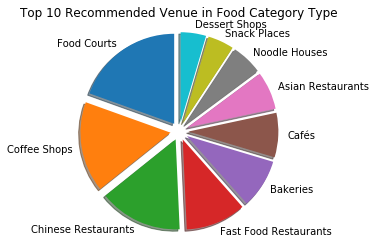

,category,VenueName
0,Food Courts,137
1,Coffee Shops,114
2,Chinese Restaurants,105
3,Fast Food Restaurants,76
4,Bakeries,62
5,Cafés,56
6,Asian Restaurants,48
7,Noodle Houses,39
8,Snack Places,33
9,Dessert Shops,32


In [28]:
top_10_venue = singapore_town_venues.groupby('category')['VenueName'].count().sort_values(ascending=False)[:10].reset_index()
labels = top_10_venue['category']
sizes  = top_10_venue['VenueName']
explode = [.1] * 10
# Plot
plt.title("Top 10 Recommended Venue in Food Category Type")
ax1 = plt.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=90)
plt.axis('equal')
plt.show()
top_10_venue

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Town']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
town_venues_sorted = pd.DataFrame(columns=columns)
town_venues_sorted['Town'] = sg_grouped['Town']

for ind in np.arange(sg_grouped.shape[0]):
    town_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

print(town_venues_sorted.shape)
town_venues_sorted

(25, 11)


,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANG MO KIO,Food Courts,Bubble Tea Shops,Fast Food Restaurants,Coffee Shops,Chinese Restaurants,Dessert Shops,Noodle Houses,Japanese Restaurants,Malay Restaurants,Pharmacies
1,BEDOK,Coffee Shops,Chinese Restaurants,Food Courts,Cafés,Bakeries,Vegetarian / Vegan Restaurants,Thai Restaurants,Sandwich Places,Indian Restaurants,Burger Joints
2,BISHAN,Coffee Shops,Chinese Restaurants,Food Courts,Fast Food Restaurants,Bakeries,Japanese Restaurants,Bubble Tea Shops,Snack Places,Cafés,Dumpling Restaurants
3,BUKIT BATOK,Food Courts,Chinese Restaurants,Coffee Shops,Asian Restaurants,Fast Food Restaurants,Bakeries,Pizza Places,Italian Restaurants,Fish & Chips Shops,Convenience Stores
4,BUKIT MERAH,Food Courts,Cafés,Coffee Shops,Asian Restaurants,Thai Restaurants,Chinese Restaurants,Seafood Restaurants,Vegetarian / Vegan Restaurants,Korean Restaurants,Bakeries
5,BUKIT PANJANG,Asian Restaurants,Coffee Shops,Bakeries,Fast Food Restaurants,Chinese Restaurants,Japanese Restaurants,American Restaurants,Cafés,Food Courts,Sandwich Places
6,CENTRAL,Cafés,Tea Rooms,Restaurants,Coffee Shops,Food Stands,Dumpling Restaurants,Eastern European Restaurants,Event Spaces,Fast Food Restaurants,Filipino Restaurants
7,CHOA CHU KANG,Coffee Shops,Bakeries,Noodle Houses,Chinese Restaurants,Dessert Shops,Cafés,Food Courts,Restaurants,Japanese Restaurants,Fast Food Restaurants
8,CLEMENTI,Food Courts,Chinese Restaurants,Fast Food Restaurants,Bakeries,Coffee Shops,Sushi Restaurants,Japanese Restaurants,Snack Places,Soup Places,Bubble Tea Shops
9,GEYLANG,Coffee Shops,Asian Restaurants,Chinese Restaurants,Noodle Houses,Vegetarian / Vegan Restaurants,Fast Food Restaurants,Seafood Restaurants,Dessert Shops,Food Courts,Frozen Yogurt Shops


Clustering Neighbourhoods

In [31]:
# set number of clusters
kclusters = 5
sg_grouped_clustering = sg_grouped.drop('Town', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])
print(len(kmeans.labels_))

[2 0 3 2 0 1 4 3 2 0]
25


In [32]:
town_venues_sorted.head()


,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANG MO KIO,Food Courts,Bubble Tea Shops,Fast Food Restaurants,Coffee Shops,Chinese Restaurants,Dessert Shops,Noodle Houses,Japanese Restaurants,Malay Restaurants,Pharmacies
1,BEDOK,Coffee Shops,Chinese Restaurants,Food Courts,Cafés,Bakeries,Vegetarian / Vegan Restaurants,Thai Restaurants,Sandwich Places,Indian Restaurants,Burger Joints
2,BISHAN,Coffee Shops,Chinese Restaurants,Food Courts,Fast Food Restaurants,Bakeries,Japanese Restaurants,Bubble Tea Shops,Snack Places,Cafés,Dumpling Restaurants
3,BUKIT BATOK,Food Courts,Chinese Restaurants,Coffee Shops,Asian Restaurants,Fast Food Restaurants,Bakeries,Pizza Places,Italian Restaurants,Fish & Chips Shops,Convenience Stores
4,BUKIT MERAH,Food Courts,Cafés,Coffee Shops,Asian Restaurants,Thai Restaurants,Chinese Restaurants,Seafood Restaurants,Vegetarian / Vegan Restaurants,Korean Restaurants,Bakeries


In [33]:
town_venues_sorted = town_venues_sorted.set_index("Town")
sg_merged = singapore_average_rental_prices_by_town.set_index("Town")
# add clustering labels
sg_merged['Cluster Labels'] = kmeans.labels_
# merge sg_grouped with singapore_average_rental_prices_by_town to add latitude/longitude for each neighborhood
sg_merged = sg_merged.join(town_venues_sorted)
sg_merged

,median_rent,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Town,,,,,,,,,,,,,,
ANG MO KIO,2066.666667,1.370073,103.849516,2,Food Courts,Bubble Tea Shops,Fast Food Restaurants,Coffee Shops,Chinese Restaurants,Dessert Shops,Noodle Houses,Japanese Restaurants,Malay Restaurants,Pharmacies
BEDOK,2120.000000,1.323976,103.930216,0,Coffee Shops,Chinese Restaurants,Food Courts,Cafés,Bakeries,Vegetarian / Vegan Restaurants,Thai Restaurants,Sandwich Places,Indian Restaurants,Burger Joints
BISHAN,2233.333333,1.350986,103.848255,3,Coffee Shops,Chinese Restaurants,Food Courts,Fast Food Restaurants,Bakeries,Japanese Restaurants,Bubble Tea Shops,Snack Places,Cafés,Dumpling Restaurants
BUKIT BATOK,1950.000000,1.349057,103.749591,2,Food Courts,Chinese Restaurants,Coffee Shops,Asian Restaurants,Fast Food Restaurants,Bakeries,Pizza Places,Italian Restaurants,Fish & Chips Shops,Convenience Stores
BUKIT MERAH,2162.500000,1.270439,103.828318,0,Food Courts,Cafés,Coffee Shops,Asian Restaurants,Thai Restaurants,Chinese Restaurants,Seafood Restaurants,Vegetarian / Vegan Restaurants,Korean Restaurants,Bakeries
BUKIT PANJANG,1750.000000,1.378629,103.762136,1,Asian Restaurants,Coffee Shops,Bakeries,Fast Food Restaurants,Chinese Restaurants,Japanese Restaurants,American Restaurants,Cafés,Food Courts,Sandwich Places
CENTRAL,2400.000000,1.340863,103.830392,4,Cafés,Tea Rooms,Restaurants,Coffee Shops,Food Stands,Dumpling Restaurants,Eastern European Restaurants,Event Spaces,Fast Food Restaurants,Filipino Restaurants
CHOA CHU KANG,1933.333333,1.384749,103.744534,3,Coffee Shops,Bakeries,Noodle Houses,Chinese Restaurants,Dessert Shops,Cafés,Food Courts,Restaurants,Japanese Restaurants,Fast Food Restaurants
CLEMENTI,2250.000000,1.315100,103.765231,2,Food Courts,Chinese Restaurants,Fast Food Restaurants,Bakeries,Coffee Shops,Sushi Restaurants,Japanese Restaurants,Snack Places,Soup Places,Bubble Tea Shops


In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], tiles="Openstreetmap", zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longitude'], sg_merged.index.values,kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters
